In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import os
import sys

In [4]:
# Path para importacion de funciones
dir_current    = os.path.abspath('')
dir_parent = os.path.dirname(dir_current)
if not dir_parent in sys.path: sys.path.append(dir_parent)

## Loading Test Data

In [2]:
(_, _), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
# Normalizando
x_test = x_test/255.
# Expandiendo dimensiones desde (28x28) a (28x28x1)
x_test = tf.expand_dims(x_test, -1)

## Creating Dataset Objects

In [5]:
from functions import to_categorical

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.map(to_categorical)
test_dataset = test_dataset.batch(1)

## Loading Quantized model and Non Quantized model 

In [6]:
from models import Lenet_body

input_layer   = tf.keras.Input((28, 28, 1))
output_layer  = Lenet_body(input_layer, Quantization = False)

#For this example we using 3 bits of precision.
Qinput_layer  = tf.keras.Input((28, 28, 1))
Qoutput_layer = Lenet_body(Qinput_layer, Quantization = True, word_size = 12, frac_size = 3)

Lenet  = tf.keras.Model(inputs=input_layer, outputs=output_layer)
QLenet = tf.keras.Model(inputs=Qinput_layer, outputs=Qoutput_layer)

## Loading Pretrained Weights

In [7]:
cwd = os.getcwd()
Wgt_dir = os.path.join(cwd,'TrainedWeights')
Wgt_dir = os.path.join(Wgt_dir,'Weights')

Lenet.load_weights(Wgt_dir)
QLenet.load_weights(Wgt_dir)

## Quantize Weights

In [8]:
from models import Weight_Quantization
Weight_Quantization(model = QLenet, Frac_Bits = 8, Int_Bits = 5)

## Checking Model predictions

In [12]:
import time
import matplotlib.pyplot as plt

# Iterator over test Dataset
iterator  = iter(test_dataset)

Target: 9
Prediction: 9
QPrediction: 9


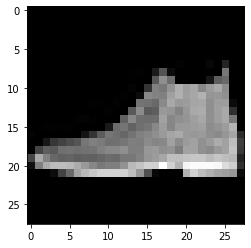

In [13]:
# Getting new image from iterator
image     = next(iterator)
image_plt = image[0][0,...,0]

# Plotting Test image
plt.imshow(image_plt, cmap='gray')

# Target
tf.print("Target:",np.argmax(image[1]))
# Predicted Output
print("Prediction:",np.argmax(Lenet.predict(image[0])))
# Quantized Predicted Output
print("QPrediction:",np.argmax(QLenet.predict(image[0])))

## Comparation of Output

In [14]:
Lenet.predict(image[0])

array([[9.4945015e-08, 7.8437586e-07, 4.5743948e-07, 2.4961669e-06,
        1.6386039e-06, 1.5448232e-03, 8.7722611e-07, 5.2541746e-03,
        1.1379937e-05, 9.9318331e-01]], dtype=float32)

In [15]:
QLenet.predict(image[0])

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

#### Classes

0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot

## Check the general Accuracy

In [17]:
# Optimization params
# -------------------

# Loss
loss = tf.keras.losses.CategoricalCrossentropy()

# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------

metrics = ['accuracy']
# ------------------

# Compile Model
Lenet.compile(optimizer=optimizer, loss=loss, metrics=metrics)
QLenet.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [20]:
Lenet.evaluate(test_dataset)

10000/10000 [==============================] - 33s 3ms/step - loss: 0.3196 - accuracy: 0.8883


[0.31960160391857567, 0.8883]

In [21]:
QLenet.evaluate(test_dataset)

10000/10000 [==============================] - 31s 3ms/step - loss: 0.6453 - accuracy: 0.8847


[0.645292562094331, 0.8847]

Notice how even with low precicion of the fractional (3 bits) the network accuracy is almost unaffected.

## Checking The Output of Each Layer

In [18]:
from functions import get_all_outputs
# List for layer names.

Layer_Names = []
for layer in Lenet.layers:
    Layer_Names.append(layer.name)

QLayer_Names = []
for layer in QLenet.layers:
    QLayer_Names.append(layer.name)
    
# Dictionary with layer name -> outputs
Layers_Outputs  = dict(zip(Layer_Names, get_all_outputs(Lenet,image[0])))
QLayers_Outputs = dict(zip(QLayer_Names, get_all_outputs(QLenet,image[0])))

## Testing Max and Min Values of Each Layer for the original model

In [ ]:
N_layers  = len(QLenet.layers)
iterator  = iter(test_dataset)
image     = next(iterator,'Stop')
Max_values = [0]*N_layers
Min_values = [0]*N_layers
while image != 'Stop':
    Model_outputs = get_all_outputs(Lenet,image[0])
    Max_iteration_values = np.array([np.max(itm) for itm in Model_outputs])
    Min_iteration_values = np.array([np.min(itm) for itm in Model_outputs])
    Max_values = np.maximum(Max_values, Max_iteration_values)
    Min_values = np.minimum(Min_values, Min_iteration_values)
    image = next(iterator,'Stop')

In [273]:
Max_values

array([ 1.        ,  1.        ,  6.51962948,  6.51962948,  0.99999565,
        0.99999565,  0.99997681, 11.36214638, 11.36214638,  1.        ,
        1.        ,  0.99999976,  0.99999976, 15.4092989 , 15.4092989 ,
        1.        ,  1.        , 10.59511375, 10.59511375,  1.        ,
        1.        , 15.80233192, 15.80233192,  0.99999881,  0.99999881])

In [274]:
Min_values

array([  0.        ,   0.        ,  -3.21593666,  -3.21593666,
        -0.9967863 ,  -0.9967863 ,  -0.99342388, -12.16223907,
       -12.16223907,  -1.        ,  -1.        ,  -0.99999869,
        -0.99999869, -15.66343212, -15.66343212,  -1.        ,
        -1.        , -11.51284122, -11.51284122,  -1.        ,
        -1.        , -11.09358406, -11.09358406,   0.        ,
         0.        ])

## Checking Max and Min values of Weights

In [9]:
for itm in Lenet.get_weights():
    print(np.max(itm))

1.6256596
0.21230586
0.9251389
0.18390743
0.62760293
0.24772961
0.54453754
0.20400645
0.72902125
0.05587189


In [10]:
for itm in Lenet.get_weights():
    print(np.min(itm))

-0.58532584
-0.2912165
-0.80219436
-0.19225334
-0.9469629
-0.23552617
-0.6235763
-0.22716506
-0.6461236
-0.07768464
